In [2]:
from NaiveBayesianDecoder import *
from StandardPCSimulation import *
from PolyFieldsPCSimulation import *
import time

import pandas as pd
totalpath = 'G:\YSY\Simulaiton_pc'

def simulating_test(TestID, shuffle_name = ''):
    n = TestID
    mkdir(os.path.join(totalpath,'test'+shuffle_name))
    file = pd.read_excel(os.path.join(totalpath,'Decoding_Test_Records.xlsx'), sheet_name = 'Simulating_Test')

    file.loc[n-1,'Time begin'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    if TestID > len(file):
        print("TestID wrong.")
        return

    print("  1. Initiate key parameters...")
    # initiate key parameters:
    if np.isnan(file['Neuron Number'][n-1]):
        n_neuron = 1000  # default value = 400
    else:
        n_neuron = int(file['Neuron Number'][n-1])
        
    if np.isnan(file['nx'][n-1]):
        nx = 48   # default value = 48
    else:
        nx = int(file['nx'][n-1])
    
    if np.isnan(file['Testing Size'][n-1]):
        testing_size = 0.1
    else:
        testing_size = file['Testing Size'][n-1]
        
    training_size = 1-testing_size
    
    if np.isnan(file['Simulated Maze Type'][n-1]):
        print("Simulated Maze Type should not be empty!")
        return
    else:
        maze_type = int(file['Simulated Maze Type'][n-1])
        
    if np.isnan(file['Total Frame Size'][n-1]):
        T = 6000
    else:
        T = int(file['Total Frame Size'][n-1])
    
    if file['Loss function type'][n-1] not in ['d','d2','0-1']:
        Loss = 'd2'
    else:
        Loss = str(file['Loss function type'][n-1])
        
    if np.isnan(file['Sigma Low'][n-1]):
        sigma_low = 4
    else:
        sigma_low = file['Sigma Low'][n-1]
        
    if np.isnan(file['Sigma High'][n-1]):
        sigma_high = 6
    else:
        sigma_high = file['Sigma High'][n-1]
    
    if np.isnan(file['Peak Rate Low'][n-1]):
        peak_low = 0.6
    else:
        peak_low = file['Peak Rate Low'][n-1]
        
    if np.isnan(file['Peak Rate High'][n-1]):
        peak_high = 0.8
    else:
        peak_high = file['Peak Rate High'][n-1]
        
    if file['Place Cell Type'][n-1] not in ['Standard','PolyFields']:
        cell_type = 'PolyFields'
    else:
        cell_type = file['Place Cell Type'][n-1]
    
    # Generate PCPopulations by simulating or read existed PCPopulation_test.pkl file
    print("  2. Generating  PCPopulation:",end='')
    if os.path.exists(str(file['Data File'][n-1])) == False:
        print(" Simulating...")
        if cell_type == 'Standard':
            PCPopulation = StandardPCSimulation(n = n_neuron, maze_type = maze_type, nx = nx**2, 
                                   sigma_low = sigma_low, sigma_high = sigma_high, peak_low = peak_low, peak_high = peak_high)
        elif cell_type == 'PolyFields':
            with open('FieldNumber_Probability.pkl','rb') as handle:
                p = pickle.load(handle)[maze_type]
            PCPopulation = PolyFieldsPCSimulator(n = n_neuron, maze_type = maze_type, nx = nx**2, 
                                   sigma_low = sigma_low, sigma_high = sigma_high, peak_low = peak_low, peak_high = peak_high,
                                                 possibility = p)
        PCPopulation.Generate_TrainingSet(T = T)
        PCPopulation.Simulate_RateMap()
        data_type = 'Simulated'
    else:
        data_type = 'Read file'
        print(" Read in existed file "+file['Data File'][n-1])
        with open(str(file['Data File'][n-1]), 'rb') as handle:
            PCPopulation = pickle.load(handle)
            print(type(PCPopulation))
            
    T = PCPopulation.T
    n_neuorn = PCPopulation.n

    # Preprocessing the PCPopulation
    print("  3. Preprocessing the simulated place cells' data and split the complete data into training set and testing set.")
    Spikes = PCPopulation.Spikes_sequence
    spike_nodes = PCPopulation.MazeID_sequence
    
    training_size = int(T * training_size)
    rand_idx = np.array(range(0,training_size), dtype = np.int64)
    notrand_idx = np.array(range(training_size, Spikes.shape[1]), dtype = np.int64)
    Spikes_train = Spikes[:,rand_idx]
    MazeID_train = spike_nodes[rand_idx]
    Spikes_test = Spikes[:,notrand_idx]
    MazeID_test = spike_nodes[notrand_idx]
    
    print("  4. Fiting BayesModel...")
    BayesModel = NaiveBayesDecoder(res = nx, maze_type = maze_type, l = 0.01, Loss_function = Loss)
    BayesModel.fit(Spikes_train,MazeID_train)
    BayesModel.predict(Spikes_test,MazeID_test)
        
    # Assess the results.
    print("  5. Assessing the results...")
    AbD = BayesModel.metrics_MSE()
    print(AbD)
    HitRate = BayesModel.metrics_Accuracy()
    print(HitRate)
    
    with open(os.path.join(totalpath,'test'+shuffle_name,'PCSimulation_test'+str(TestID)+'.pkl'), 'wb') as f:
        pickle.dump(PCPopulation,f)
    
    with open(os.path.join(totalpath,'test'+shuffle_name,'PCPrediction_test'+str(TestID)+'.pkl'), 'wb') as f:
        pickle.dump(BayesModel,f)

    # Saving the test's information.
    print("  6. Saving test results...")
    file.loc[n-1,'Simulator Version'] = PCPopulation.version
    file.loc[n-1,'Decoder Version'] = BayesModel.version
        
    file.loc[n-1,'MAE'] = BayesModel.MAE
    file.loc[n-1,'RMSE'] = BayesModel.RMSE
    file.loc[n-1,'absolute Accuracy'] = BayesModel.abHit
    file.loc[n-1,'Loss function type'] = Loss
    file.loc[n-1,'Sigma Low'] = sigma_low
    file.loc[n-1,'Sigma High'] = sigma_high
    file.loc[n-1,'Peak Rate Low'] = peak_low
    file.loc[n-1,'Peak Rate High'] = peak_high
    file.loc[n-1,'Place Cell Type'] = cell_type
    if nx != 12:
        file.loc[n-1, 'general Accuracy'] = BayesModel.geHit
    file.loc[n-1,'nx'] = nx
    file.loc[n-1,'Neuron Number'] = n_neuorn
    file.loc[n-1,'Total Frame Size'] = T
    file.loc[n-1,'Testing Size'] = testing_size
    file.loc[n-1,'Data Type'] = data_type
    if data_type == 'Simulated':
        file.loc[n-1,'Data File'] = os.path.join(totalpath,'test'+shuffle_name,'PCSimulation_test'+str(TestID)+'.pkl')
    file.loc[n-1,'Results File'] = os.path.join(totalpath,'test'+shuffle_name,'PCPrediction_test'+str(TestID)+'.pkl')
    file.loc[n-1,'Time end'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    file.to_excel(os.path.join(totalpath,'Decoding_Test_Records_output.xlsx'), sheet_name = "Simulating_Test")
    print("Finish.")

simulating_test(36)

    G:\YSY\Simulaiton_pc\test is already existed!
  1. Initiate key parameters...
  2. Generating  PCPopulation: Simulating...
     Generate possibility matrix...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.18it/s]


     Generate simulated spike sequence...


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [03:34<00:00, 28.02it/s]


  Simulation finish.


G:\YSY\Simulaiton_pc\PolyFieldsPCSimulation.py:206: RuntimeWarning: invalid value encountered in true_divide
  rate_map_simulated = spike_freq_all / count_freq * 30


    Rate map has been generated from simulated spike sequence.
  3. Preprocessing the simulated place cells' data and split the complete data into training set and testing set.
  4. Fiting BayesModel...
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
  Tuning curve successfully generated!
    Generating P matirx...


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.54it/s]


  5. Assessing the results...
MSE
10.56535217901735
(111.62666666666667, 273.08649537382024, 10.56535217901735, 8.02585160089867)
Accuracy
(0.023333333333333334, 0.2733333333333333)
  6. Saving test results...
Finish.


In [2]:
from mylib.maze_utils3 import *

with open(r'G:\YSY\Simulaiton_pc\test\PCSimulation_test30.pkl','rb') as handle:
    PCPopulation = pickle.load(handle)

print(PCPopulation.V)

[0.68956773 0.66521675 0.68835938 0.64140229 0.67527185 0.78871219
 0.65165983 0.71998715 0.70467595 0.74399745 0.61431345 0.71014662
 0.73596201 0.790497   0.73558222 0.6596705  0.64432221 0.64795563
 0.71333596 0.7599264  0.6393482  0.63819293 0.73942316 0.64342353
 0.79589299 0.69020688 0.77716825 0.60447642 0.6698636  0.62067222
 0.76027587 0.60388353 0.71682888 0.65231379 0.6888249  0.71716772
 0.73954914 0.67585117 0.70731124 0.73977586 0.66631165 0.76326678
 0.76774901 0.64142105 0.74324054 0.630004   0.6400567  0.60428067
 0.70258468 0.63944968 0.79641335 0.73669976 0.68498122 0.71347408
 0.7605533  0.75577824 0.74745796 0.70973372 0.68759273 0.63228334
 0.6573223  0.71284792 0.64137025 0.62680317 0.73798391 0.66301144
 0.76099009 0.76229767 0.66925313 0.63850486 0.74980703 0.66533159
 0.73780685 0.70077314 0.63113288 0.61323672 0.76207379 0.63964413
 0.67824811 0.75381726 0.78873786 0.79519003 0.6581653  0.6178769
 0.71908498 0.75319649 0.66970935 0.69098815 0.65295039 0.73353

In [ ]:
from mylib.maze_utils3 import *

with open(r'G:\YSY\Simulaiton_pc\test\PCPrediction_test7.pkl','rb') as handle:
    PCPopulation = pickle.load(handle)

print(PCPopulation.PeakRate)

    G:\YSY\Simulaiton_pc\Simulated rate map test26 is made up successfully!


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.00it/s]


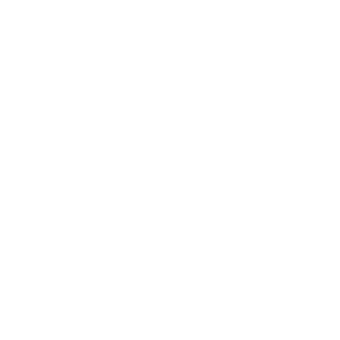

In [2]:
from mylib.maze_utils3 import *

fig = plt.figure(figsize = (8,6))
axes = Clear_Axes(axes = plt.axes())

testID = 26
totalpath = 'G:\YSY\Simulaiton_pc'
p = os.path.join(totalpath,'Simulated rate map test'+str(testID))
mkdir(p)

with open(r'G:\YSY\Simulaiton_pc\test\PCSimulation_test'+str(testID)+'.pkl','rb') as handle:
    PCPopulation = pickle.load(handle)

for i in tqdm(range(PCPopulation.PM.shape[0])):
    im = axes.imshow(np.reshape(PCPopulation.PM[i,:], [48,48]))
    cbar = plt.colorbar(im, ax = axes)
    plt.savefig(os.path.join(p,'Cell '+str(i+1)), dpi = 150)
    cbar.remove()
    im.remove()
    

In [11]:
from mylib.maze_utils3 import *

with open('trace_maze0.pkl','rb') as handle:
    trace = pickle.load(handle)
    
speed = trace['behav_speed']
speed[speed>=62.5] = 62.499
speed = speed/2.5
speed_p = np.zeros(25,dtype = np.float64)
for i in tqdm(range(len(speed))):
    a = int(speed[i])
    speed_p[a] += 1
print(speed_p)
speed_p = speed_p / np.nansum(speed_p)
with open('speed_distribution.pkl','wb') as f:
    pickle.dump(speed_p,f)
    

100%|████████████████████████████████████████████████████████████████████████| 31807/31807 [00:00<00:00, 523721.99it/s]

[6.2700e+02 1.6000e+01 4.0000e+01 1.4200e+02 4.0500e+02 3.0300e+02
 3.6600e+02 3.7000e+02 2.9100e+02 2.7600e+02 3.0200e+02 3.0400e+02
 3.4100e+02 3.5400e+02 3.5300e+02 3.2600e+02 3.2200e+02 3.1100e+02
 3.7100e+02 3.1500e+02 3.2800e+02 2.6700e+02 3.1900e+02 2.8500e+02
 2.4473e+04]


In [12]:
print(sum(speed_p))

1.0
